# M03. Predict PAs
- This predicts the outcome of plate appearances
- Type: Model
- Run Frequency: Irregular
- Sources:
    - MLB API
    - Steamer
- Created: 4/19/2024
- Updated: 6/4/2025

Consider: 
- imputed starter, imputed reliever, unimputed starter, unimputed reliever variables
- Using batter woba and pitcher woba to determine quantiles, not projected

### Imports

In [1]:
%run "U1. Imports.ipynb"
%run "U2. Functions.ipynb"
%run "U3. Classes.ipynb"
%run "U4. Datasets.ipynb"
%run "U5. Models.ipynb"

In [2]:
# Set option to display numbers without scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

### Data

##### Park x Weather Factors

In [3]:
multiplier_df = pd.read_csv(os.path.join(baseball_path, "Park and Weather Factors.csv"))

Choose WFX
- _unadj: predicted based on weather / predicted based on batted ball <br>
- _adj: average of actual rates in similarly predicted games / predicted based on batted ball

In [4]:
wfx_type = 'adj'
for event in events_list:
    multiplier_df[f'{event}_wfx_l'] = multiplier_df[f'{event}_wfx_{wfx_type}_l'].copy()
    multiplier_df[f'{event}_wfx_r'] = multiplier_df[f'{event}_wfx_{wfx_type}_r'].copy()

##### Plate Appearances

In [5]:
complete_dataset = pd.read_csv(os.path.join(baseball_path, "Final Dataset.csv"))

##### Steamer

In [6]:
steamer_hitters_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_hitters_weekly_log.csv"), encoding='iso-8859-1')

In [7]:
steamer_pitchers_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_pitchers_weekly_log.csv"), encoding='iso-8859-1')

### Clean

##### MLB Stats API

In [8]:
complete_dataset = complete_dataset[~complete_dataset[batter_inputs].isin([np.inf, -np.inf]).any(axis=1)]
complete_dataset = complete_dataset[~complete_dataset[pitcher_inputs].isin([np.inf, -np.inf]).any(axis=1)]

In [9]:
%%time
complete_dataset[batter_inputs] = scale_batter_stats.transform(complete_dataset[batter_inputs])
complete_dataset[pitcher_inputs] = scale_pitcher_stats.transform(complete_dataset[pitcher_inputs])

CPU times: total: 1.78 s
Wall time: 1.8 s


##### Steamer

Clean

In [10]:
steamer_hitters_df2 = clean_steamer_hitters(steamer_hitters_df)
steamer_hitters_df2.dropna(subset=batter_stats_fg, inplace=True)

Scale

In [11]:
steamer_hitters_df2[batter_stats_fg] = scale_batter_stats_steamer.transform(steamer_hitters_df2[batter_stats_fg])

Read in pitchers

Clean

In [12]:
steamer_pitchers_df2 = clean_steamer_pitchers(steamer_pitchers_df)
steamer_pitchers_df2.dropna(subset=pitcher_stats_fg2, inplace=True)

Scale

In [13]:
steamer_pitchers_df2[pitcher_stats_fg] = scale_pitcher_stats_steamer.transform(steamer_pitchers_df2[pitcher_stats_fg])

##### Merge

Format dates

In [14]:
complete_dataset['date_time'] = pd.to_datetime(complete_dataset['date'], format='%Y%m%d')
complete_dataset['date_time_copy'] = complete_dataset['date_time'].copy()
steamer_hitters_df2['date_time'] = pd.to_datetime(steamer_hitters_df2['date'], format='%Y%m%d')
steamer_pitchers_df2['date_time'] = pd.to_datetime(steamer_pitchers_df2['date'], format='%Y%m%d')

steamer_hitters_df2.rename(columns={'mlbamid': 'batter'}, inplace=True)
steamer_pitchers_df2.rename(columns={'mlbamid': 'pitcher'}, inplace=True)

Sort to prep for merge

In [15]:
complete_dataset.sort_values('date_time', inplace=True)
steamer_hitters_df2.sort_values('date_time', inplace=True)
steamer_pitchers_df2.sort_values('date_time', inplace=True)

Drop unnecessary columns

In [16]:
steamer_hitters_df2.drop(columns=['date', 'firstname', 'lastname', 'steamerid'], inplace=True)
steamer_pitchers_df2.drop(columns=['date', 'firstname', 'lastname', 'steamerid'], inplace=True)

Remove missing pitchers (occurs occassionally in 2014)

In [17]:
steamer_pitchers_df2 = steamer_pitchers_df2[~steamer_pitchers_df2['pitcher'].isna()].reset_index(drop=True)

Set data types

In [18]:
complete_dataset['batter'] = complete_dataset['batter'].astype(int).astype(str)
complete_dataset['pitcher'] = complete_dataset['pitcher'].astype(int).astype(str)
steamer_hitters_df2['batter'] = steamer_hitters_df2['batter'].astype(int).astype(str)
steamer_pitchers_df2['pitcher'] = steamer_pitchers_df2['pitcher'].astype(int).astype(str)

Merge asof most recent date in Steamer

In [19]:
complete_merged_df = pd.merge_asof(
    complete_dataset,
    steamer_hitters_df2,
    on='date_time',
    by='batter',  # Group by 'batter'
    direction='backward'  # Use 'backward', 'forward', or 'nearest' as appropriate
)
# Correct datetime (might be unnecessary, but I'm not sure which date_time it takes after the merge)
complete_merged_df['date_time'] = complete_merged_df['date_time_copy'].copy()

complete_merged_df = pd.merge_asof(
    complete_merged_df,
    steamer_pitchers_df2,
    on='date_time',
    by='pitcher',  # Group by 'batter'
    direction='backward'  # Use 'backward', 'forward', or 'nearest' as appropriate
)

Merge WFX

In [20]:
complete_merged_df = pd.merge(complete_merged_df, multiplier_df, on=['gamePk', 'date', 'venue_id'], how='left')

##### Impute

For players with insufficient sample sizes, stats are imputed

Option 1: Steamer

First, remove from dataset if ever missing FG/Steamer stats

In [21]:
complete_merged_df = complete_merged_df[~complete_merged_df['b1_rate'].isna()]
complete_merged_df = complete_merged_df[~complete_merged_df['H9'].isna()]

In [22]:
# Add hands to use in imputation
batter_stats_fg_imp = batter_stats_fg + ['b_L', 'p_L', 'imp_b']
pitcher_stats_fg_imp = pitcher_stats_fg + ['b_L', 'p_L', 'imp_p']

### Batters
# Use Steamer stats to predict API/Statcast stats for those with limited samples
batter_predictions = impute_batter_stats.predict(complete_merged_df.loc[complete_merged_df['pa_b'] < 40, batter_stats_fg_imp])

# Impute inputs with limited sample size with predicted values
complete_merged_df.loc[complete_merged_df['pa_b'] < 40, batter_inputs] = batter_predictions

### Pitchers
# Use Steamer stats to predict API/Statcast stats for those with limited samples
pitcher_predictions = impute_pitcher_stats.predict(complete_merged_df.loc[complete_merged_df['pa_p'] < 40, pitcher_stats_fg_imp])

# Impute inputs with limited sample size with predicted values
complete_merged_df.loc[complete_merged_df['pa_p'] < 40, pitcher_inputs] = pitcher_predictions

Option 2: 0s

In [23]:
# # Testing instead of imputing, just weighting with 0s
# complete_merged_df[batter_inputs].fillna(0, inplace=True)
# complete_merged_df[pitcher_inputs].fillna(0, inplace=True)

# # Calculate the weighted average for each column in pitcher_stats
# # Could be simplified, but I wanted to show the steps
# # Weighted average of provided value and 0. PAs and 50-PAs are weights. 
# for col in batter_inputs:
#     complete_merged_df[col] = (complete_merged_df[col] * complete_merged_df['pa_b'] + 0 * (50-complete_merged_df['pa_b']))/50

# # Calculate the weighted average for each column in pitcher_stats
# for col in pitcher_inputs:
#     complete_merged_df[col] = (complete_merged_df[col] * complete_merged_df['pa_p'] + 0 * (50-complete_merged_df['pa_p']))/50

### Select Data

Drop early observations

In [24]:
complete_merged_df = complete_merged_df[complete_merged_df['game_date'] > '2015-07-01']

Drop atypical events

In [25]:
complete_merged_df = complete_merged_df.query('eventsModel != "Cut"')

Drop observations from inactive parks

In [26]:
active_parks = list(team_map['VENUE_ID'].astype(int))
complete_merged_df = complete_merged_df[complete_merged_df['venue_id'].astype(int).isin(active_parks)]

### Select Variables

Batter Inputs

In [27]:
batter_input_list = batter_inputs

Pitcher Inputs

In [28]:
pitcher_input_list = pitcher_inputs

Hand Inputs

In [29]:
hand_input_list = ['p_L', 'b_L']

Imputation Inputs

In [30]:
imp_input_list = ['imp_b', 'imp_p']

Starter Input(s)

In [31]:
starter_input_list = ['starter']

Cumulative Inning Inputs

In [32]:
cumulative_inning_input_list = [col for col in complete_merged_df.columns if col.endswith("_inning")]

In [33]:
cumulative_inning_input_list.remove('rbi_inning')

Cumulative Game Inputs

In [34]:
cumulative_game_input_list = [col for col in complete_merged_df.columns if col.endswith("_game")]

In [35]:
cumulative_game_input_list.remove('rbi_game')

Game State Inputs

In [36]:
complete_merged_df['winning'] = (complete_merged_df['preBatterScore'] > complete_merged_df['prePitcherScore']).astype(int)
complete_merged_df['winning_big'] = (complete_merged_df['preBatterScore'] > complete_merged_df['prePitcherScore'] + 3).astype(int)

In [37]:
game_state_input_list = ['onFirst', 'onSecond', 'onThird', 'top', 'score_diff', 'prePitcherScore', 'preBatterScore', 'winning', 'winning_big', 'times_faced']

Inning Inputs

In [38]:
for inning in range(1, 12):
    complete_merged_df[f'inning_{inning}'] = (complete_merged_df['inning'] == inning).astype(int)
complete_merged_df['inning_11'] = (complete_merged_df['inning'] >= 11).astype(int)

In [39]:
inning_input_list = [col for col in complete_merged_df.columns if col.startswith("inning_")]

Out Inputs

In [40]:
for out in range(0, 3):
    complete_merged_df[f'outs_{out}'] = (complete_merged_df['outs_pre'] == out).astype(int)

In [41]:
out_input_list = ['outs_0', 'outs_1', 'outs_2']

Venue Inputs

In [42]:
complete_merged_df['venue_id2'] = complete_merged_df['venue_id'].copy()
complete_merged_df = pd.get_dummies(complete_merged_df, columns=['venue_id2'], prefix='venue')

In [43]:
venue_input_list = [col for col in complete_merged_df.columns if col.startswith("venue_") and col != "venue_id" and col != "venue_name"]

Multiplier Inputs

In [44]:
for event in events_list:
    # Assign multiplier for their batSide
    complete_merged_df[f'{event}_wfx'] = np.where(complete_merged_df['batSide'] == "L", complete_merged_df[f'{event}_wfx_l'], 
                                                                                        complete_merged_df[f'{event}_wfx_r'])

In [45]:
multiplier_input_list = [f'{event}_wfx' for event in events_list]

Imputation and starter interactions

In [46]:
complete_merged_df['imputed_starter'] = complete_merged_df['imp_p'] * complete_merged_df['starter']
complete_merged_df['imputed_reliever'] = complete_merged_df['imp_p'] * (complete_merged_df['starter'] == 0).astype(int)
complete_merged_df['unimputed_starter'] = (complete_merged_df['imp_p'] == 0).astype(int) * complete_merged_df['starter']
complete_merged_df['unimputed_reliever'] = (complete_merged_df['imp_p'] == 0).astype(int) * (complete_merged_df['starter'] == 0).astype(int)

In [47]:
imp_starter_input_list = ['imputed_starter', 'imputed_reliever', 'unimputed_starter', 'unimputed_reliever']

Inputs

In [48]:
input_list = batter_input_list + pitcher_input_list + hand_input_list + imp_input_list + starter_input_list + cumulative_inning_input_list + cumulative_game_input_list + game_state_input_list + inning_input_list + out_input_list + venue_input_list + multiplier_input_list

Outputs

In [49]:
output_list = ['is_out', 'eventsModel']

Other variables

In [50]:
additional_list = ['pa_b', 'pa_p', 'year', 'date', 'gamePk', 'atBatIndex', 'venue_id', 'batterName', 'pitcherName']

Variables to keep

In [51]:
keep_list = input_list + output_list + additional_list

### Shift

Many batter and pitcher stats are calculated at the end of the plate appearance. For prediction purposes, we need these stats coming into the plate appearance.

##### Batter Inputs

Sort

In [52]:
complete_merged_df.sort_values(['date', 'gamePk', 'atBatIndex'], ascending=True, inplace=True)

Shift

In [53]:
complete_merged_df[batter_inputs + ['ab_b', 'pa_b', 'imp_b']] = complete_merged_df.groupby(['batter', 'pitchHand'])[batter_inputs + ['ab_b', 'pa_b', 'imp_b']].shift(1)

##### Pitcher Inputs

Sort

In [54]:
complete_merged_df.sort_values(['date', 'gamePk', 'atBatIndex'], ascending=True, inplace=True)

Shift

In [55]:
complete_merged_df[pitcher_inputs + ['ab_p', 'pa_p', 'imp_p']] = complete_merged_df.groupby(['pitcher', 'batSide'])[pitcher_inputs + ['ab_p', 'pa_p', 'imp_p']].shift(1)

##### Inning Sums

Sort

In [56]:
complete_merged_df.sort_values(['date', 'gamePk', 'atBatIndex'], ascending=True, inplace=True)

Shift

In [57]:
complete_merged_df[cumulative_inning_input_list] = complete_merged_df.groupby(['gamePk', 'inning', 'pitcher'])[cumulative_inning_input_list].shift(1)
complete_merged_df[cumulative_inning_input_list] = complete_merged_df[cumulative_inning_input_list].fillna(0)

##### Game Sums

Sort

In [58]:
complete_merged_df.sort_values(['date', 'gamePk', 'atBatIndex'], ascending=True, inplace=True)

Shift

In [59]:
complete_merged_df[cumulative_game_input_list + ['times_faced']] = complete_merged_df.groupby(['gamePk', 'pitcher'])[cumulative_game_input_list + ['times_faced']].shift(1)
complete_merged_df[cumulative_game_input_list + ['times_faced']] = complete_merged_df[cumulative_game_input_list + ['times_faced']].fillna(0)

### TESTING: Adding stat differentials

In [60]:
diff_list = events_list + ['estimated_woba_using_speedangle', 'hard_hit', 'barrel'] + calc_list
diff_list = ['woba']


diff_list_long = []
for stat in diff_list:
    complete_merged_df[f'{stat}_d_long'] = complete_merged_df[f'{stat}_b_long'] - (1 - complete_merged_df[f'{stat}_p_long'])
    diff_list_long.append(f'{stat}_d_long')

keep_list += diff_list_long + imp_starter_input_list

### Model Dataset

Create Model Dataset

In [61]:
model_dataset = complete_merged_df[keep_list]

model_dataset.dropna(subset=input_list, inplace=True)
model_dataset.reset_index(drop=True, inplace=True)

Free up memory

In [62]:
del complete_merged_df, complete_dataset, steamer_hitters_df, steamer_hitters_df2, steamer_pitchers_df, steamer_pitchers_df2, multiplier_df, batter_predictions, pitcher_predictions

In [63]:
n1 = len(input_list) + 1

### Train/Test Split

Split

In [64]:
np.random.seed(42)
model_dataset['split'] = np.random.choice([0, 0, 1], size=len(model_dataset))

Create masks to identify training and testing datasets

Note: to train on the entire dataset, you can simply set split = 0 for the entire dataset

In [65]:
training_mask = (model_dataset['split'] == 0)

In [66]:
def constructed_stats(model_dataset):
    # FP - Outs
    model_dataset.loc[~training_mask, 'FP_P_act'] = ((model_dataset.loc[~training_mask, 'eventsModel'] == "fo").astype(int) * 0.2534 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "go").astype(int) * 0.2534 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "po").astype(int) * 0.2534 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "lo").astype(int) * 0.2534 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "so").astype(int) * 2.4866)

    model_dataset.loc[~training_mask, 'FP_P_pred'] = (model_dataset[~training_mask]['fo_pred'] * 0.2534 +
                                                      model_dataset[~training_mask]['go_pred'] * 0.2534 +
                                                      model_dataset[~training_mask]['po_pred'] * 0.2534 + 
                                                      model_dataset[~training_mask]['lo_pred'] * 0.2534 +
                                                      model_dataset[~training_mask]['so_pred'] * 2.4866)

    # FP - Safe
    model_dataset.loc[~training_mask, 'FP_B_act'] = ((model_dataset.loc[~training_mask, 'eventsModel'] == "b1").astype(int)  *  4.3665 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "b2").astype(int)  *  6.8271 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "b3").astype(int)  * 10.8503 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "hr").astype(int)  * 15.2611 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "bb").astype(int)  *  2.8725 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "hbp").astype(int) *  2.9639)

    model_dataset.loc[~training_mask, 'FP_B_pred'] = (model_dataset[~training_mask]['b1_pred']  *  4.3665 +
                                                      model_dataset[~training_mask]['b2_pred']  *  6.8271 +
                                                      model_dataset[~training_mask]['b3_pred']  * 10.8503 + 
                                                      model_dataset[~training_mask]['hr_pred']  * 15.2611 +
                                                      model_dataset[~training_mask]['bb_pred']  *  2.8725 +
                                                      model_dataset[~training_mask]['hbp_pred'] *  2.9639)

    # wOBA (roughly)
    model_dataset.loc[~training_mask, 'wOBA_act'] = ((model_dataset.loc[~training_mask, 'eventsModel'] == "b1").astype(int)  * 0.882 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "b2").astype(int)  * 1.254 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "b3").astype(int)  * 1.590 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "hr").astype(int)  * 2.050 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "bb").astype(int)  * 0.689 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "hbp").astype(int) * 0.720)

    model_dataset.loc[~training_mask, 'wOBA_pred'] = (model_dataset[~training_mask]['b1_pred']  * 0.882 +
                                                      model_dataset[~training_mask]['b2_pred']  * 1.254 +
                                                      model_dataset[~training_mask]['b3_pred']  * 1.590 + 
                                                      model_dataset[~training_mask]['hr_pred']  * 2.050 +
                                                      model_dataset[~training_mask]['bb_pred']  * 0.689 +
                                                      model_dataset[~training_mask]['hbp_pred'] * 0.720)
    
    # Out
    model_dataset['is_out_act'] = model_dataset['is_out'].copy()
    
    model_dataset.loc[~training_mask, 'is_out_pred'] = (model_dataset[~training_mask]['fo_pred'] +
                                                        model_dataset[~training_mask]['go_pred'] +
                                                        model_dataset[~training_mask]['po_pred'] + 
                                                        model_dataset[~training_mask]['lo_pred'] +
                                                        model_dataset[~training_mask]['so_pred'])


    # Actual Stats
    for event in events_list:
        model_dataset[f'{event}_act'] = (model_dataset['eventsModel'] == event).astype(int)


    return model_dataset
    

In [67]:
input_list = batter_input_list + pitcher_input_list + hand_input_list + imp_input_list + starter_input_list + cumulative_inning_input_list + cumulative_game_input_list + game_state_input_list + inning_input_list + out_input_list + imp_starter_input_list
len(input_list)

157

In [95]:
model_dataset.groupby('imp_p')['so_p'].mean()

imp_p
0.000000   -0.546283
1.000000   -0.576723
Name: so_p, dtype: float64

In [93]:
model_dataset[model_dataset['imp_p'] == 1].head()

,b1_b,b2_b,b3_b,bb_b,fo_b,go_b,hbp_b,hr_b,lo_b,po_b,so_b,estimated_woba_using_speedangle_b,to_left_b,to_middle_b,to_right_b,hard_hit_b,barrel_b,iso_b,slg_b,obp_b,woba_b,totalDistance_b,launchSpeed_b,b1_b_long,b2_b_long,b3_b_long,bb_b_long,fo_b_long,go_b_long,hbp_b_long,hr_b_long,lo_b_long,po_b_long,so_b_long,estimated_woba_using_speedangle_b_long,to_left_b_long,to_middle_b_long,to_right_b_long,hard_hit_b_long,barrel_b_long,iso_b_long,slg_b_long,obp_b_long,woba_b_long,totalDistance_b_long,launchSpeed_b_long,b1_p,b2_p,b3_p,bb_p,fo_p,go_p,hbp_p,hr_p,lo_p,po_p,so_p,estimated_woba_using_speedangle_p,to_left_p,to_middle_p,to_right_p,hard_hit_p,barrel_p,iso_p,slg_p,obp_p,woba_p,maxSpeed_p,maxSpin_p,b1_p_long,b2_p_long,b3_p_long,bb_p_long,fo_p_long,go_p_long,hbp_p_long,hr_p_long,lo_p_long,po_p_long,so_p_long,estimated_woba_using_speedangle_p_long,to_left_p_long,to_middle_p_long,to_right_p_long,hard_hit_p_long,barrel_p_long,iso_p_long,slg_p_long,obp_p_long,woba_p_long,maxSpeed_p_long,maxSpin_p_long,p_L,b_L,imp_b,imp_p,starter,b1_inning,b2_inning,b3_inning,bb_inning,fo_inning,go_inning,hbp_inning,hr_inning,lo_inning,po_inning,so_inning,h_inning,tb_inning,reached_inning,faced_inning,outs_pa_inning,b1_game,b2_game,b3_game,bb_game,fo_game,go_game,hbp_game,hr_game,lo_game,po_game,so_game,h_game,tb_game,reached_game,faced_game,outs_pa_game,onFirst,onSecond,onThird,top,score_diff,prePitcherScore,preBatterScore,winning,winning_big,times_faced,inning_1,inning_2,inning_3,inning_4,inning_5,inning_6,inning_7,inning_8,inning_9,inning_10,inning_11,outs_0,outs_1,outs_2,venue_1,venue_2,venue_3,venue_4,venue_5,venue_7,venue_10,venue_12,venue_14,venue_15,venue_17,venue_19,venue_22,venue_31,venue_32,venue_680,venue_2392,venue_2394,venue_2395,venue_2602,venue_2680,venue_2681,venue_2889,venue_3289,venue_3309,venue_3312,venue_3313,venue_4169,venue_4705,venue_5325,b1_wfx,b2_wfx,b3_wfx,bb_wfx,fo_wfx,go_wfx,hbp_wfx,hr_wfx,lo_wfx,po_wfx,so_wfx,is_out,eventsModel,pa_b,pa_p,year,date,gamePk,atBatIndex,venue_id,batterName,pitcherName,woba_d_long,imputed_starter,imputed_reliever,unimputed_starter,unimputed_reliever,split,b1_pred,b2_pred,b3_pred,bb_pred,fo_pred,go_pred,hbp_pred,hr_pred,lo_pred,po_pred,so_pred,FP_P_act,FP_P_pred,FP_B_act,FP_B_pred,wOBA_act,wOBA_pred,is_out_act,is_out_pred,b1_act,b2_act,b3_act,bb_act,fo_act,go_act,hbp_act,hr_act,lo_act,po_act,so_act,hr_wfx_decile,b1_quantile,b2_quantile,b3_quantile,bb_quantile,fo_quantile,go_quantile,hbp_quantile,hr_quantile,lo_quantile,po_quantile,so_quantile,is_out_quantile,wOBA_quantile,FP_B_quantile,FP_P_quantile,b1_pred1,b2_pred1,b3_pred1,bb_pred1,fo_pred1,go_pred1,hbp_pred1,hr_pred1,lo_pred1,po_pred1,so_pred1,b1_int,b2_int,b3_int,bb_int,fo_int,go_int,hbp_int,hr_int,lo_int,po_int,so_int,hr_wfx_quantile
50,-0.861376,-0.911713,-0.945222,-0.760000,-0.863862,-0.627689,-1.000000,-0.885470,-0.928173,-0.960442,-0.160000,-0.458247,-0.840000,-0.760000,-0.560000,-0.440000,-0.880000,-0.839808,-0.788130,-0.438861,-0.701609,0.552475,0.783564,-0.808538,-0.873728,-0.899251,-0.780000,-0.785200,-0.620074,-0.980000,-0.890754,-0.887796,-0.965138,-0.353333,-0.513033,-0.786667,-0.626667,-0.500000,-0.493333,-0.813333,-0.830858,-0.758494,-0.358756,-0.662768,0.754455,0.858421,-0.449836,-0.574733,-0.532571,-0.605961,-0.840735,0.174415,-0.744437,-0.627038,-0.469088,-0.463161,-0.427478,-0.514027,-0.351298,-0.172393,-0.298443,-0.388680,-0.633757,-0.652715,-0.706467,-0.455317,-0.549841,0.045941,-0.062447,-0.344885,-0.680259,-0.564601,-0.610970,-0.695790,0.165572,-0.389155,-0.633161,-0.415084,-0.509571,-0.391578,-0.540352,-0.476744,-0.273369,-0.340013,-0.465442,-0.682075,-0.652992,-0.532155,-0.403375,-0.540597,0.082621,-0.226255,False,True,0.000000,1.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

### Model 1. All - Unadjusted

In [68]:
all_stat_list = []

##### Settings

In [77]:
layers = (128, 64, 32)
activation = 'relu'
max_iter = 100
alpha = 0.0000
learning_rate_init = 0.001 
batch_size='auto'
batch_size=256
random_state = random.randint(10000,99900)
dropout = 0.1 # Need to switch to MLPDropout to use
early_stopping = True
tol=0.00001
n_iter_no_change=20
validation_fraction = 0.05
num_models = 40
num_classifiers = 3

quantiles = 10
year = 2024 
venue = 19

len(input_list)

157

Model 0: predict_all_1286432_63780_20250812.sav
Voting Classifier

Imputation Status x Starter
                  FP_P_pred  FP_P_act  wOBA_pred  wOBA_act  so_pred   so_act
imp_p    starter                                                            
0.000000 0         0.705590  0.699360   0.307592  0.304471 0.237539 0.235091
         1         0.677408  0.668573   0.312411  0.310887 0.224461 0.220756
1.000000 0         0.667211  0.684454   0.325834  0.308740 0.222689 0.229723
         1         0.612530  0.617412   0.336997  0.338876 0.198239 0.201149

Pitcher: Imputation Status
          FP_P_pred  FP_P_act  wOBA_pred  wOBA_act  so_pred   so_act
imp_p                                                               
0.000000   0.688740  0.680953   0.310473  0.308307 0.229720 0.226520
1.000000   0.645155  0.657412   0.330337  0.320896 0.212827 0.218198

Batter: Imputation Status
          FP_B_pred  FP_B_act  wOBA_pred  wOBA_act  hr_pred   hr_act
imp_b                                      

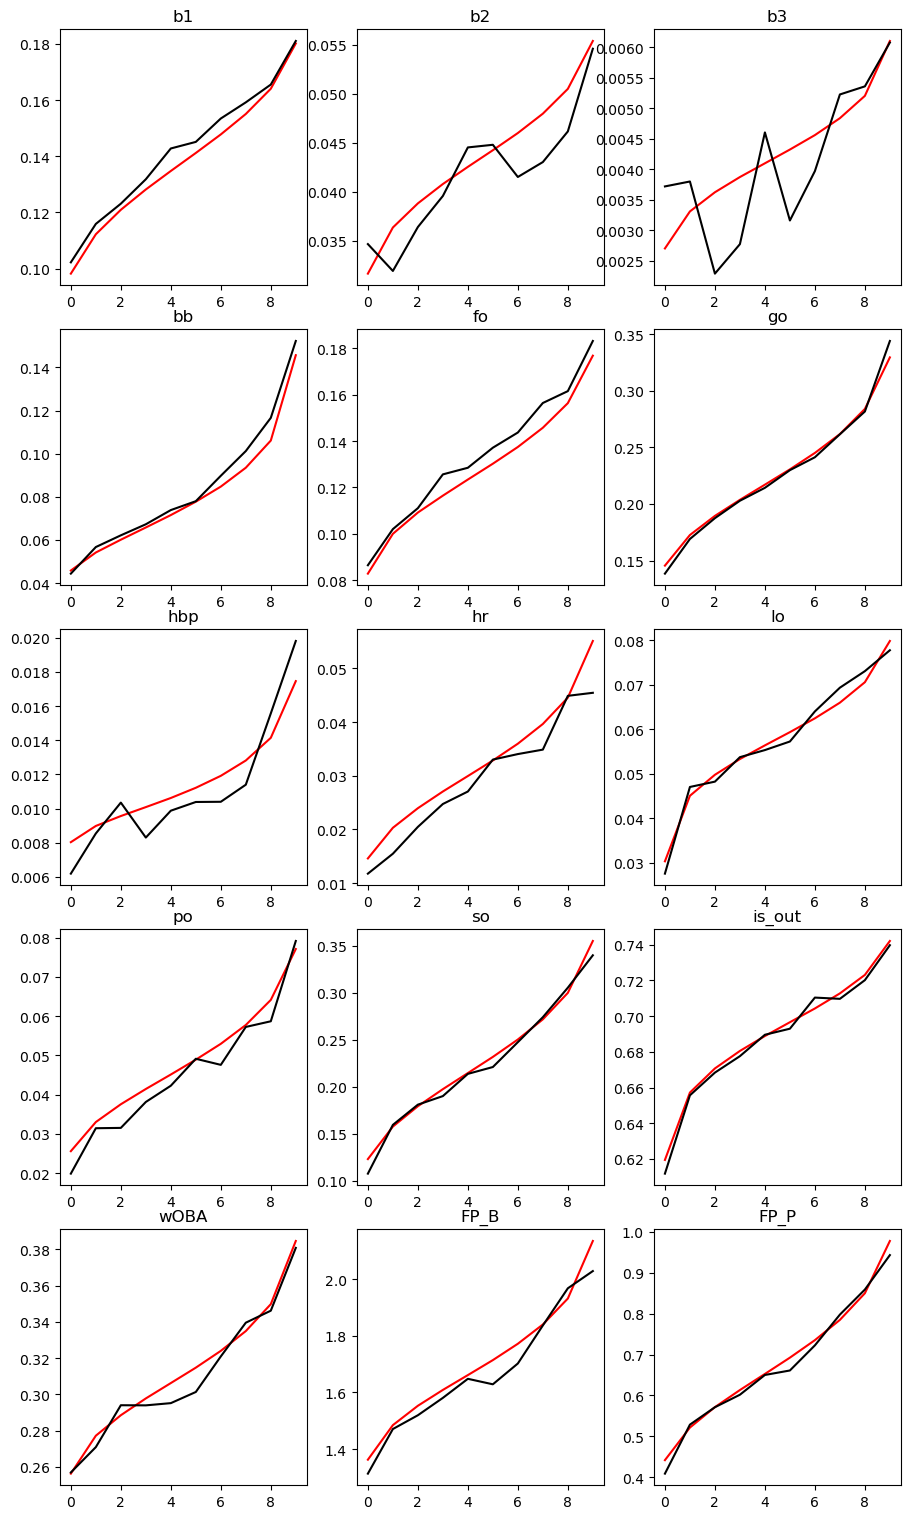

Model 1: predict_all_1286432_63781_20250812.sav
Voting Classifier

Imputation Status x Starter
                  FP_P_pred  FP_P_act  wOBA_pred  wOBA_act  so_pred   so_act
imp_p    starter                                                            
0.000000 0         0.683293  0.699360   0.320825  0.304471 0.229031 0.235091
         1         0.641675  0.668573   0.326785  0.310887 0.209857 0.220756
1.000000 0         0.663641  0.684454   0.329881  0.308740 0.221845 0.229723
         1         0.596789  0.617412   0.345296  0.338876 0.192052 0.201149

Pitcher: Imputation Status
          FP_P_pred  FP_P_act  wOBA_pred  wOBA_act  so_pred   so_act
imp_p                                                               
0.000000   0.658411  0.680953   0.324388  0.308307 0.217567 0.226520
1.000000   0.636676  0.657412   0.336099  0.320896 0.209828 0.218198

Batter: Imputation Status
          FP_B_pred  FP_B_act  wOBA_pred  wOBA_act  hr_pred   hr_act
imp_b                                      

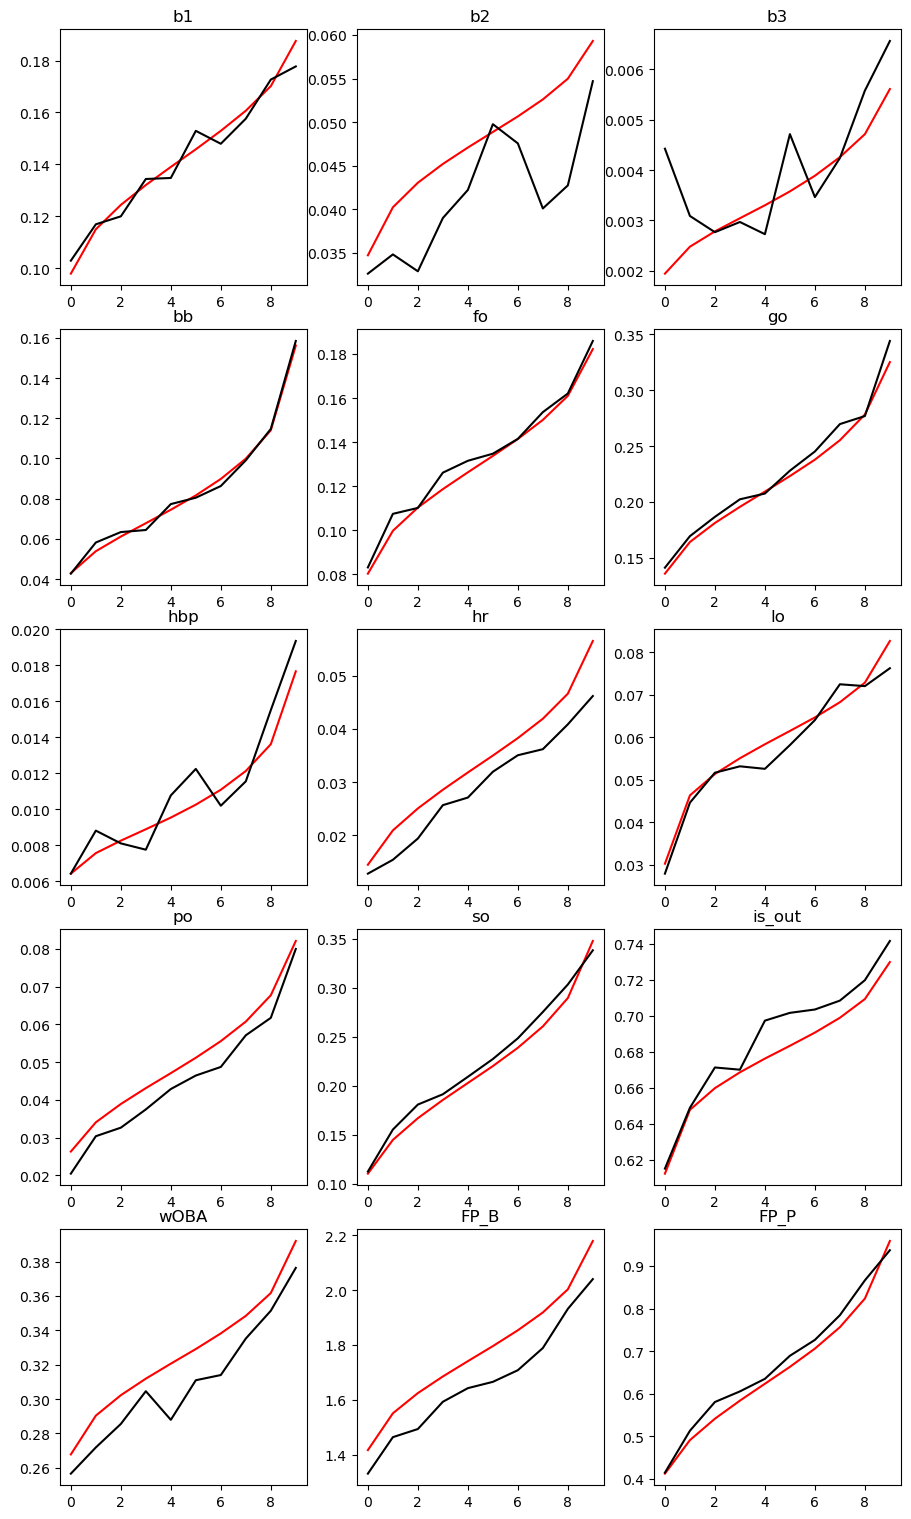

Model 2: predict_all_1286432_63782_20250812.sav
Voting Classifier

Imputation Status x Starter
                  FP_P_pred  FP_P_act  wOBA_pred  wOBA_act  so_pred   so_act
imp_p    starter                                                            
0.000000 0         0.717569  0.699360   0.303706  0.304471 0.242963 0.235091
         1         0.683460  0.668573   0.309023  0.310887 0.227042 0.220756
1.000000 0         0.676049  0.684454   0.317146  0.308740 0.226418 0.229723
         1         0.625441  0.617412   0.327356  0.338876 0.203429 0.201149

Pitcher: Imputation Status
          FP_P_pred  FP_P_act  wOBA_pred  wOBA_act  so_pred   so_act
imp_p                                                               
0.000000   0.697176  0.680953   0.306885  0.308307 0.233444 0.226520
1.000000   0.655636  0.657412   0.321264  0.320896 0.217145 0.218198

Batter: Imputation Status
          FP_B_pred  FP_B_act  wOBA_pred  wOBA_act  hr_pred   hr_act
imp_b                                      

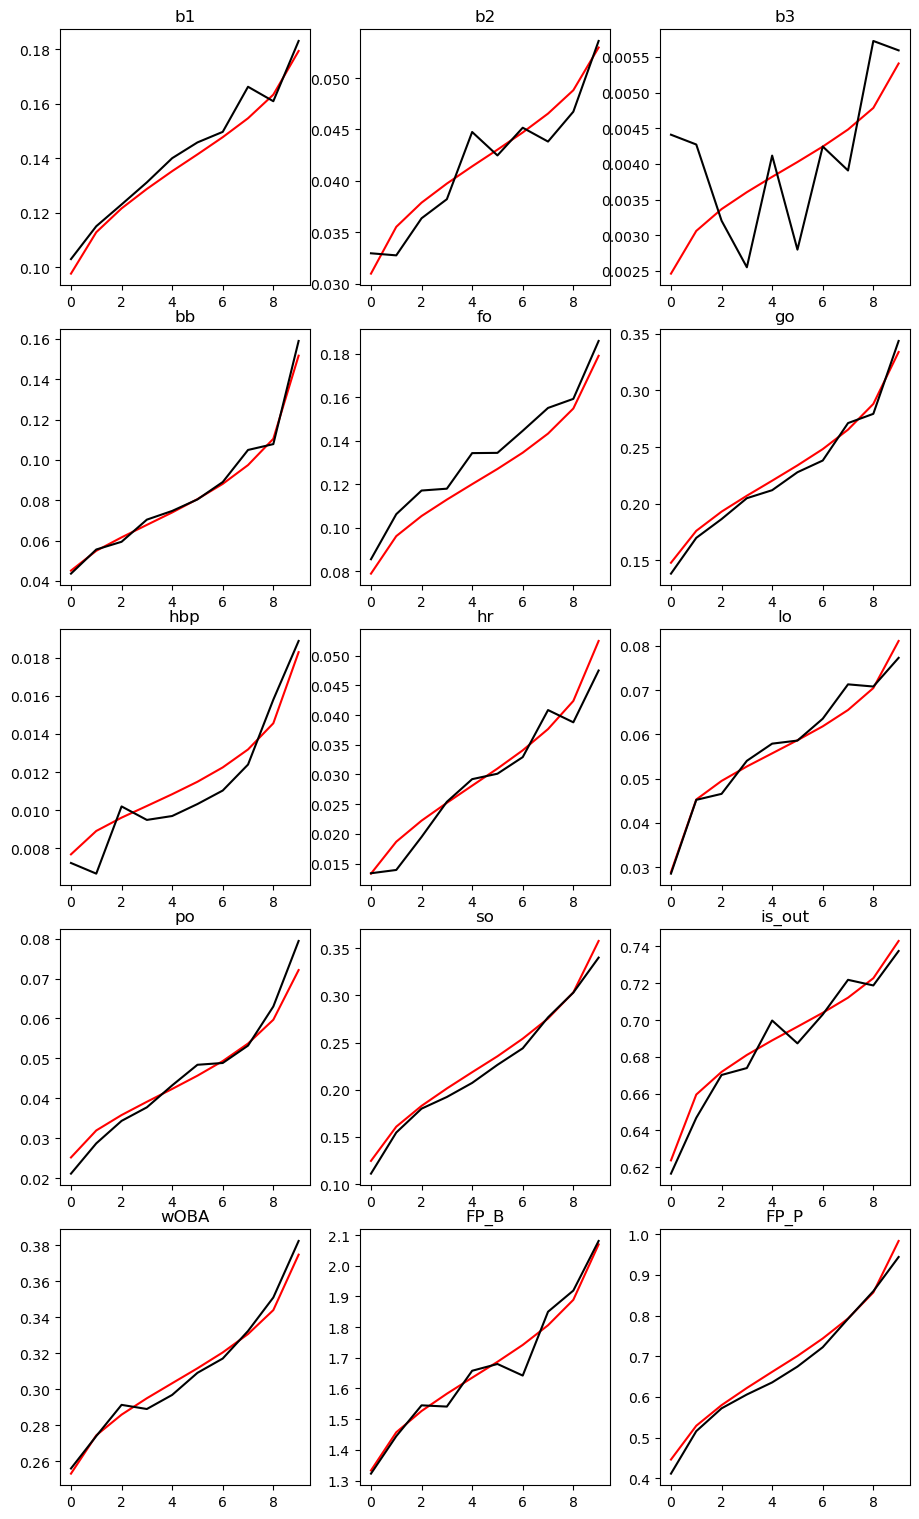

Model 3: predict_all_1286432_63783_20250812.sav
Voting Classifier

Imputation Status x Starter
                  FP_P_pred  FP_P_act  wOBA_pred  wOBA_act  so_pred   so_act
imp_p    starter                                                            
0.000000 0         0.692547  0.699360   0.314203  0.304471 0.233263 0.235091
         1         0.660993  0.668573   0.319822  0.310887 0.218461 0.220756
1.000000 0         0.665577  0.684454   0.326901  0.308740 0.223135 0.229723
         1         0.616209  0.617412   0.338419  0.338876 0.200701 0.201149

Pitcher: Imputation Status
          FP_P_pred  FP_P_act  wOBA_pred  wOBA_act  so_pred   so_act
imp_p                                                               
0.000000   0.673682  0.680953   0.317562  0.308307 0.224413 0.226520
1.000000   0.645664  0.657412   0.331547  0.320896 0.214086 0.218198

Batter: Imputation Status
          FP_B_pred  FP_B_act  wOBA_pred  wOBA_act  hr_pred   hr_act
imp_b                                      

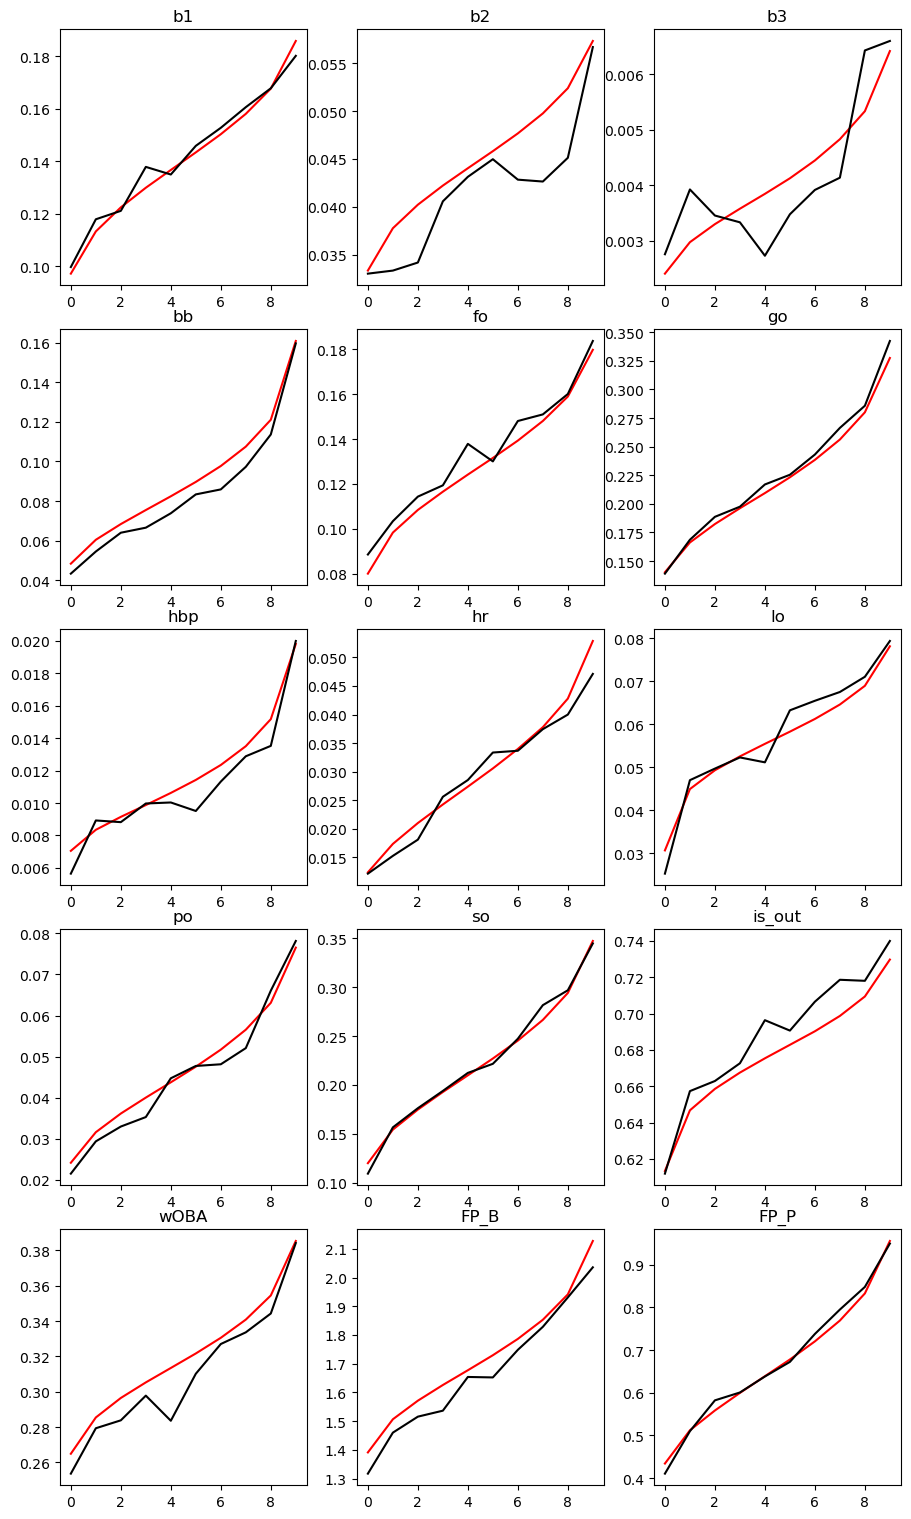

Model 4: predict_all_1286432_63784_20250812.sav
Voting Classifier

Imputation Status x Starter
                  FP_P_pred  FP_P_act  wOBA_pred  wOBA_act  so_pred   so_act
imp_p    starter                                                            
0.000000 0         0.696999  0.699360   0.314219  0.304471 0.234396 0.235091
         1         0.662229  0.668573   0.321451  0.310887 0.218483 0.220756
1.000000 0         0.672814  0.684454   0.326720  0.308740 0.225256 0.229723
         1         0.620746  0.617412   0.338501  0.338876 0.201892 0.201149

Pitcher: Imputation Status
          FP_P_pred  FP_P_act  wOBA_pred  wOBA_act  so_pred   so_act
imp_p                                                               
0.000000   0.676211  0.680953   0.318543  0.308307 0.224882 0.226520
1.000000   0.651812  0.657412   0.331472  0.320896 0.215832 0.218198

Batter: Imputation Status
          FP_B_pred  FP_B_act  wOBA_pred  wOBA_act  hr_pred   hr_act
imp_b                                      

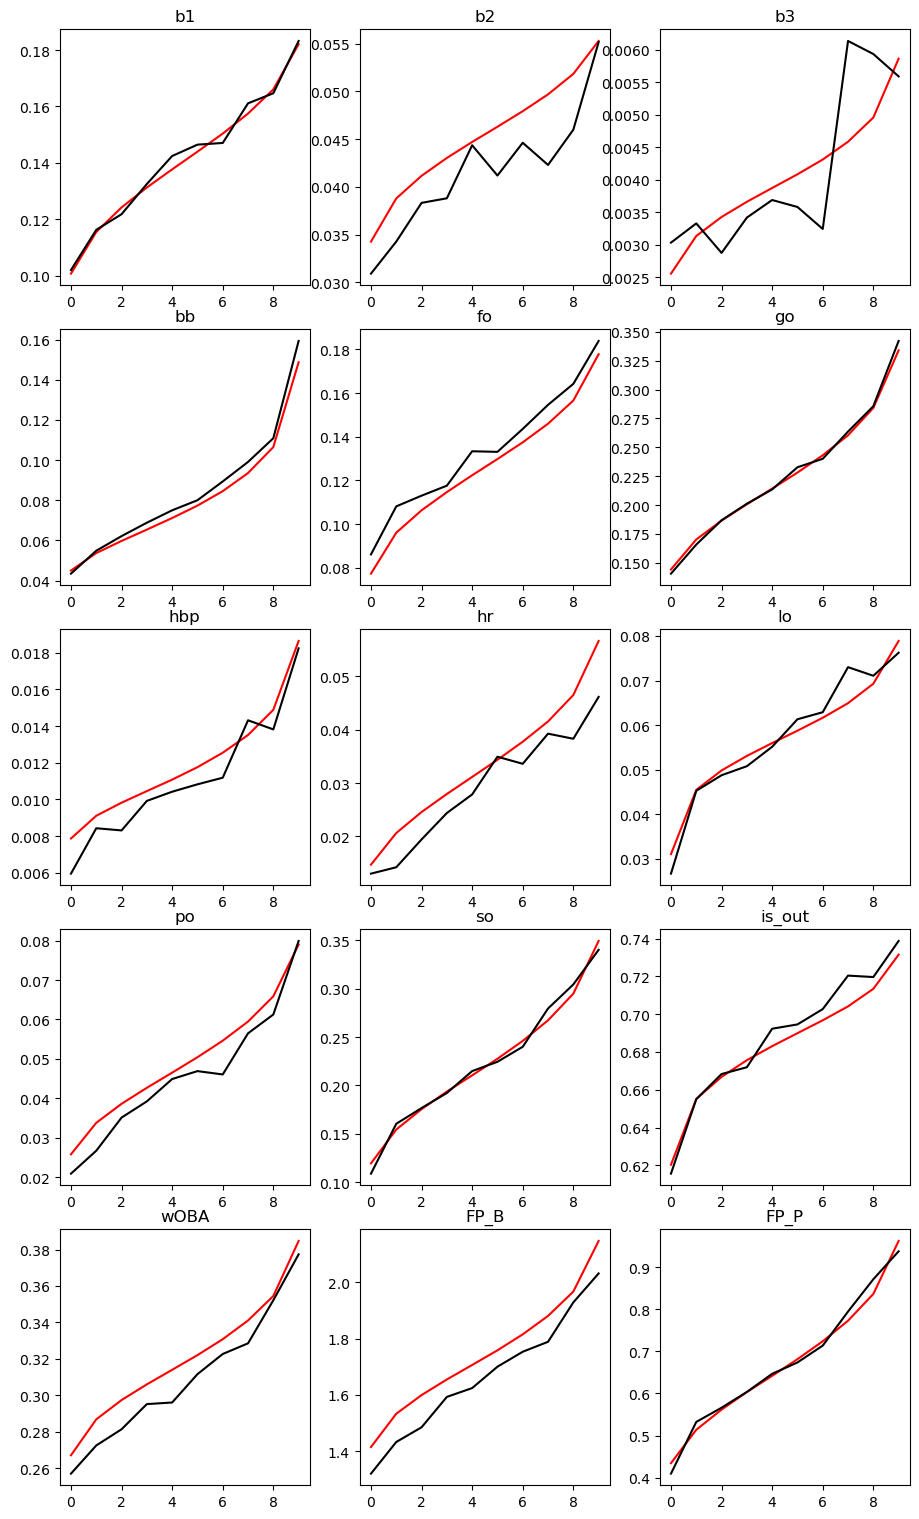

Model 5: predict_all_1286432_63785_20250812.sav
Voting Classifier



KeyboardInterrupt



In [78]:
%%time
for i in range(num_models):
    ### File
    all_filename = f"predict_all_{''.join(str(x) for x in layers)}_{random_state+i}_{todaysdate}.sav"
    print(f"Model {i}: {all_filename}")

    ### Determine if voting
    if num_classifiers > 1:
        print("Voting Classifier")
        # Build list of MLP classifiers with varied random_state
        estimators = []
        for j in range(num_classifiers):
            clf = MLPClassifier(
                hidden_layer_sizes=layers,
                activation=activation,
                verbose=True,
                alpha=alpha,
                learning_rate_init=learning_rate_init,
                early_stopping=early_stopping,
                random_state=random_state + i + j * 100,
                max_iter=max_iter,
                tol=tol,
                n_iter_no_change=n_iter_no_change,
                batch_size=batch_size
            )
            estimators.append((f"mlp_{j}", clf))
        
        # Combine into a soft voting classifier
        predict_all = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

    else:
        print("Single Classifier")
        # Create Model
        predict_all = MLPClassifier(hidden_layer_sizes=layers, 
                                    activation=activation, 
                                    verbose=True, 
                                    alpha=alpha, 
                                    learning_rate_init=learning_rate_init, 
                                    early_stopping=early_stopping, 
                                    random_state=random_state+i, 
                                    max_iter=max_iter,
                                    tol=tol, 
                                    n_iter_no_change=n_iter_no_change,
                                    batch_size=batch_size, 
                                    validation_fraction=validation_fraction)

    ### Fit
    predict_all.fit(model_dataset[training_mask][input_list], model_dataset[training_mask][['eventsModel']].values.ravel())

    ### Save
    pickle.dump(predict_all, open(os.path.join(model_path, "M03. Plate Appearances", all_filename), 'wb'))
    
    ### Predict
    all_outputs = list(predict_all.classes_)
    all_outputs_pred = [x + "_pred" for x in all_outputs]
    model_dataset.loc[~training_mask, all_outputs_pred] = predict_all.predict_proba(model_dataset[~training_mask][input_list])


    ### Constructed Stats
    model_dataset = constructed_stats(model_dataset)


    ### Summary Statistics
    print("\nImputation Status x Starter")
    print(model_dataset[~training_mask].query('year == 2024').groupby(['imp_p', 'starter'])[['FP_P_pred', 'FP_P_act', 'wOBA_pred', 'wOBA_act', 'so_pred', 'so_act']].mean())
    print("\nPitcher: Imputation Status")
    print(model_dataset[~training_mask].query('year == 2024').groupby(['imp_p'])[['FP_P_pred', 'FP_P_act', 'wOBA_pred', 'wOBA_act', 'so_pred', 'so_act']].mean())
    print("\nBatter: Imputation Status")
    print(model_dataset[~training_mask].query('year == 2024').groupby(['imp_b'])[['FP_B_pred', 'FP_B_act', 'wOBA_pred', 'wOBA_act', 'hr_pred', 'hr_act']].mean())
    print("\nVenue")
    print(model_dataset[~training_mask].query('year == 2024').groupby('venue_id')[['FP_B_pred', 'FP_B_act', 'FP_P_pred', 'FP_P_act']].mean())
    print("\nHR Deciles")
    model_dataset['hr_wfx_decile'] = pd.qcut(model_dataset['hr_wfx'], q=10, labels=False) + 1
    print(model_dataset[~training_mask].query('year == 2024').groupby('hr_wfx_decile')[['hr_pred', 'hr_act']].mean())
    print("\n")
    
    ### Quantiles
    # Loop over metrics
    for var in all_outputs + ['is_out', 'wOBA', 'FP_B', 'FP_P']:        
        # Calculate quantiles
        model_dataset.loc[~training_mask, f'{var}_quantile'] = pd.qcut(model_dataset.loc[~training_mask, f'{var}_pred'], quantiles, labels=False, duplicates='drop')
        
        # Create aggregated dataframe
        globals()[f"{var}_df"] = model_dataset.loc[~training_mask].groupby(f'{var}_quantile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
        globals()[f"{var}_year_df"] = model_dataset.query(f'year >= {year}').loc[~training_mask].groupby(f'{var}_quantile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
        globals()[f"{var}_venue_df"] = model_dataset.query(f'venue_id == {venue}').loc[~training_mask].groupby(f'{var}_quantile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
    
    ### All Years
    all_df_list = []
    for var in all_outputs + ['is_out', 'wOBA', 'FP_B', 'FP_P']:
        actual = model_dataset.loc[~training_mask][f'{var}_act'].mean()
        predicted = model_dataset.loc[~training_mask][f'{var}_pred'].mean()
        mult = actual/predicted
        stdev = model_dataset.loc[~training_mask][f'{var}_pred'].std()
        globals()[f"{var}_df"]['se'] = (globals()[f"{var}_df"][f'{var}_act'] - globals()[f"{var}_df"][f'{var}_pred']) ** 2
        mse = globals()[f"{var}_df"]['se'].mean()
        all_df = pd.DataFrame(["All", var, actual, predicted, mult, stdev, mse])
        all_df_list.append(all_df)
    
    all_dfs = pd.concat(all_df_list, axis=1).T
    
    ### Specific Year
    recent_df_list = []
    for var in all_outputs + ['is_out', 'wOBA', 'FP_B', 'FP_P']:
        actual = model_dataset.query(f'year >= {year}').loc[~training_mask][f'{var}_act'].mean()
        predicted = model_dataset.query(f'year == {year}').loc[~training_mask][f'{var}_pred'].mean()
        mult = actual/predicted
        stdev = model_dataset.query(f'year == {year}').loc[~training_mask][f'{var}_pred'].std()
        globals()[f"{var}_year_df"]['se'] = (globals()[f"{var}_year_df"][f'{var}_act'] - globals()[f"{var}_year_df"][f'{var}_pred']) ** 2
        mse = globals()[f"{var}_year_df"]['se'].mean()
        recent_df = pd.DataFrame([str(int(year)), var, actual, predicted, mult, stdev, mse])
        recent_df_list.append(recent_df)
    
    recent_dfs = pd.concat(recent_df_list, axis=1).T
    
    ### Outcome Summary
    all_stat_df = pd.concat([all_dfs, recent_dfs], axis=0).reset_index(drop=True)
    all_stat_df.columns = ['Year', 'Output', 'Actual', 'Predicted', "Multiplier", 'Std. Dev', 'MSE']
    all_stat_df['File'] = all_filename
    all_stat_df['Layers'] = str(layers)
    all_stat_df['Models'] = num_models
    all_stat_df['State'] = random_state+i
    all_stat_df[['Year', 'File', 'Layers', 'Models', 'State', 'Output', 'Actual', 'Predicted', "Multiplier", 'Std. Dev', 'MSE']]

    print(all_stat_df[['Year', 'Output', 'Actual', 'Predicted', 'Multiplier', 'Std. Dev', 'MSE']])
    
    all_stat_list.append(all_stat_df)


    
    ### Graphs
    graph_options = ["", "_year", "_venue"]
    graph_index = 1
    graph = graph_options[graph_index]
    print(f"Graphing {graph}")

    rows, columns = 5, 3
    fig, axs = plt.subplots(rows, columns, figsize=(9, 15))
    
    # Ensure that the number of plots doesn't exceed available subplots
    total_plots = rows * columns
    output_vars = all_outputs + ['is_out', 'wOBA', 'FP_B', 'FP_P']
    
    # Limit the number of plots to the available subplots
    output_vars = output_vars[:total_plots]
    
    for i, var in enumerate(output_vars):
        row = i // columns  # Calculate the row index based on the iteration
        col = i % columns   # Calculate the column index based on the iteration
        axs[row, col].plot(globals()[f"{var}{graph}_df"][f'{var}_quantile'], globals()[f"{var}{graph}_df"][f'{var}_pred'], color='red')
        axs[row, col].plot(globals()[f"{var}{graph}_df"][f'{var}_quantile'], globals()[f"{var}{graph}_df"][f'{var}_act'], color='black')
        axs[row, col].set_title(var)
    
    # Add some space between subplots to prevent overlapping
    fig.tight_layout(pad=.0)
    
    # Show the figure
    plt.show()

In [79]:
all_stat_df = pd.concat(all_stat_list)
all_stat_df = all_stat_df.reset_index(drop=True)

In [80]:
subset = all_stat_df.query('Year == "2024"').query('Output == "wOBA"').query('1.01 > Multiplier > 0.99').reset_index(drop=True)
pareto_front = pareto_optimal(subset, ['MSE', 'Std. Dev'], ['Minimize', 'Maximize']).sort_values('Std. Dev')
pareto_front

,Year,Output,Actual,Predicted,Multiplier,Std. Dev,MSE,File,Layers,Models,State
0,2024,wOBA,0.308427,0.307709,1.002336,0.033772,0.000024,predict_all_1286432_63782_20250812.sav,"(128, 64, 32)",40,63782


### Predict

Load model

Note: this will overwrite predict_all model from U5. Models.ipynb

In [81]:
all_filename = "predict_all_1286432_63782_20250812.sav"

predict_all = pickle.load(open(os.path.join(model_path, "M03. Plate Appearances", all_filename), 'rb'))

Predict

In [82]:
all_outputs = list(predict_all.classes_)
all_outputs_pred = [x + "_pred1" for x in all_outputs]

model_dataset[all_outputs_pred] = predict_all.predict_proba(model_dataset[input_list])

### Model #2. WFX Adjustments

Calculate Predicted Rate x WFX Interactions

In [83]:
all_adjusted_input_list = []

for event in events_list:
    model_dataset[f'{event}_int'] = model_dataset[f'{event}_pred1'] * model_dataset[f'{event}_wfx']
    all_adjusted_input_list.append(f'{event}_int')

In [84]:
all_adjusted_stat_list = []

In [85]:
layers = (16,)
activation = 'relu'
max_iter = 100
alpha = 0.001
learning_rate_init = 0.01 
# batch_size='auto'
batch_size=1000
random_state = random.randint(10000,99900)
dropout = 0.1 # Need to switch to MLPDropout to use
early_stopping = True
tol=0.000001
n_iter_no_change=10
validation_fraction=0.05
num_models = 40
num_classifiers = 3


quantiles = 10


len(all_adjusted_input_list)

11

Model 0: predict_all_adjusted_16_79806_20250812.sav
Voting Classifier

Imputation Status x Starter
                  FP_P_pred  FP_P_act  wOBA_pred  wOBA_act  so_pred   so_act
imp_p    starter                                                            
0.000000 0         0.719690  0.699360   0.312147  0.304471 0.244236 0.235091
         1         0.683239  0.668573   0.316083  0.310887 0.227534 0.220756
1.000000 0         0.672890  0.684454   0.327010  0.308740 0.225326 0.229723
         1         0.620837  0.617412   0.336103  0.338876 0.201921 0.201149

Pitcher: Imputation Status
          FP_P_pred  FP_P_act  wOBA_pred  wOBA_act  so_pred   so_act
imp_p                                                               
0.000000   0.697897  0.680953   0.314500  0.308307 0.234250 0.226520
1.000000   0.651894  0.657412   0.330678  0.320896 0.215886 0.218198

Batter: Imputation Status
          FP_B_pred  FP_B_act  wOBA_pred  wOBA_act  hr_pred   hr_act
imp_b                                  

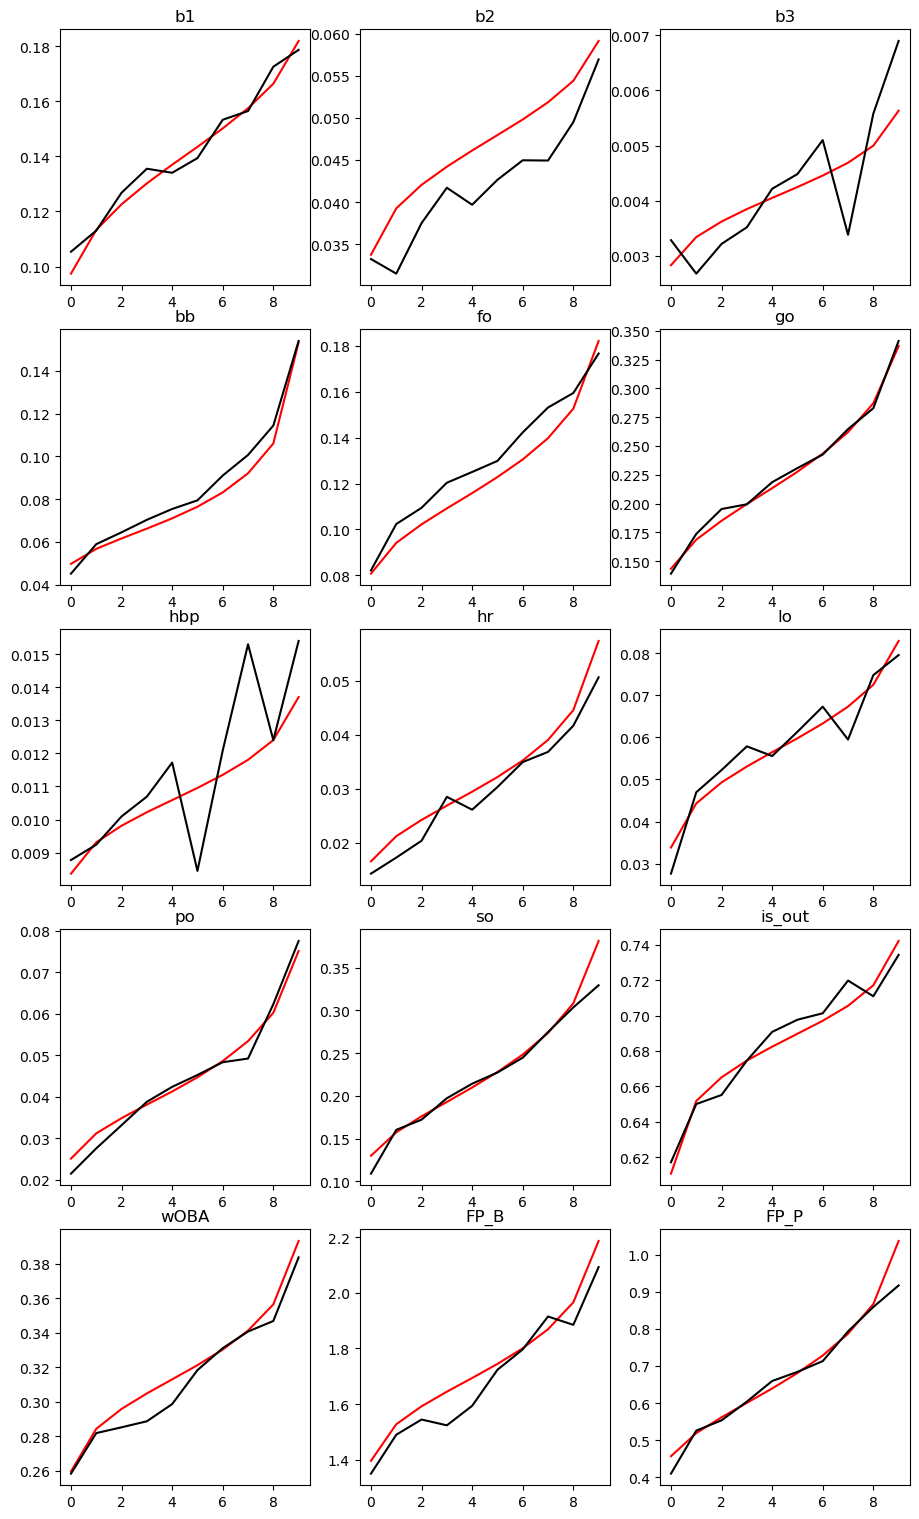

Model 1: predict_all_adjusted_16_79807_20250812.sav
Voting Classifier

Imputation Status x Starter
                  FP_P_pred  FP_P_act  wOBA_pred  wOBA_act  so_pred   so_act
imp_p    starter                                                            
0.000000 0         0.715128  0.699360   0.302903  0.304471 0.241825 0.235091
         1         0.681349  0.668573   0.307735  0.310887 0.226155 0.220756
1.000000 0         0.673096  0.684454   0.316330  0.308740 0.224994 0.229723
         1         0.622126  0.617412   0.327056  0.338876 0.202066 0.201149

Pitcher: Imputation Status
          FP_P_pred  FP_P_act  wOBA_pred  wOBA_act  so_pred   so_act
imp_p                                                               
0.000000   0.694933  0.680953   0.305792  0.308307 0.232456 0.226520
1.000000   0.652536  0.657412   0.320656  0.320896 0.215746 0.218198

Batter: Imputation Status
          FP_B_pred  FP_B_act  wOBA_pred  wOBA_act  hr_pred   hr_act
imp_b                                  

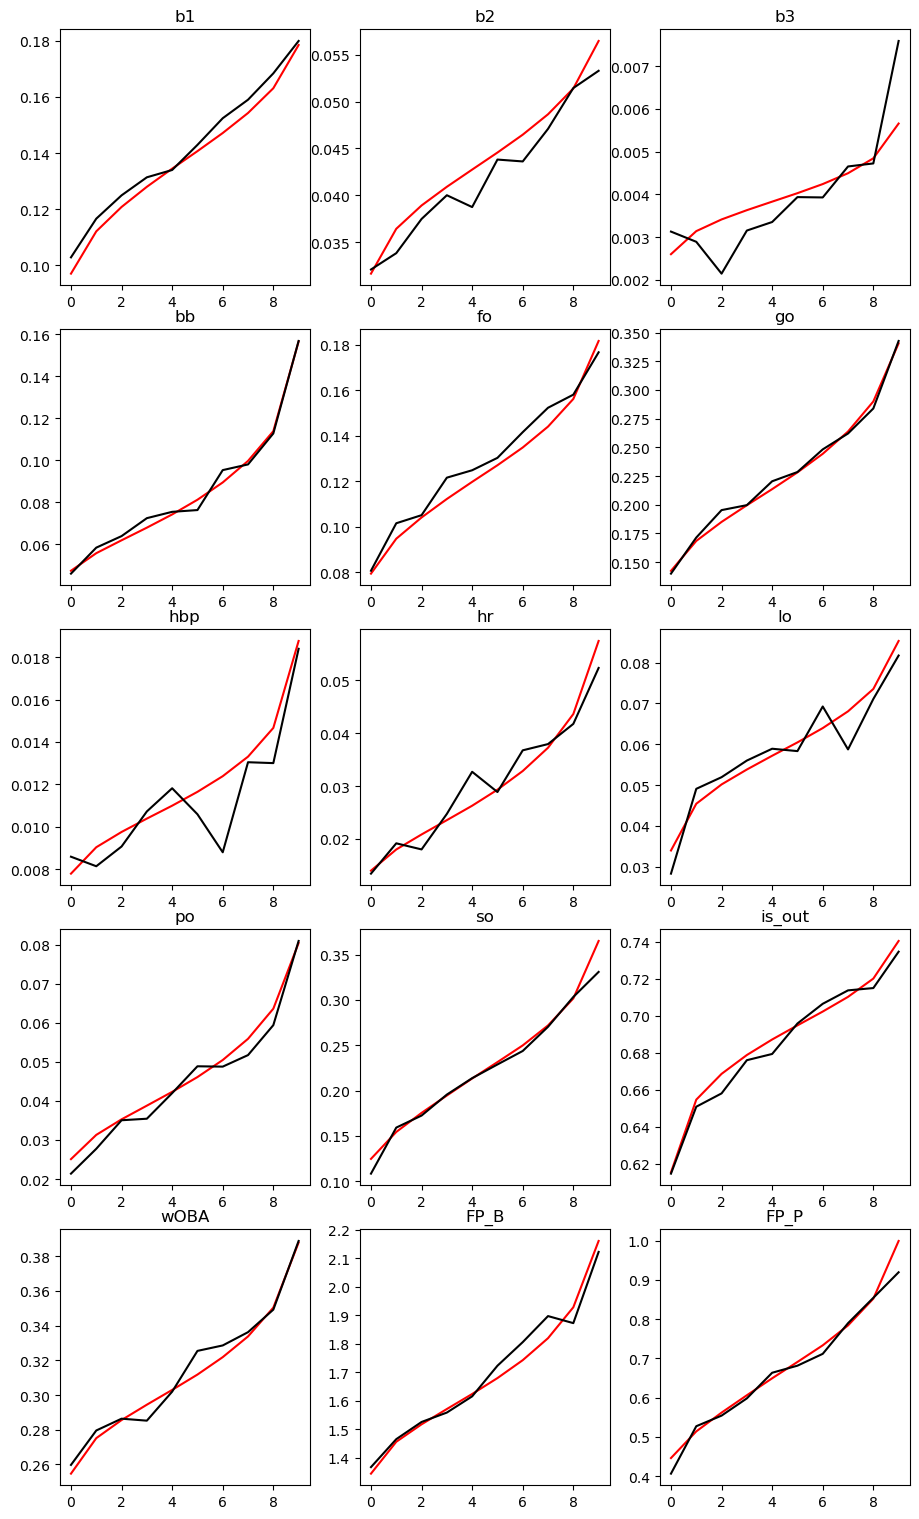

Model 2: predict_all_adjusted_16_79808_20250812.sav
Voting Classifier

Imputation Status x Starter
                  FP_P_pred  FP_P_act  wOBA_pred  wOBA_act  so_pred   so_act
imp_p    starter                                                            
0.000000 0         0.714388  0.699360   0.298107  0.304471 0.241020 0.235091
         1         0.679799  0.668573   0.301827  0.310887 0.224990 0.220756
1.000000 0         0.669261  0.684454   0.311376  0.308740 0.222815 0.229723
         1         0.619226  0.617412   0.318897  0.338876 0.200038 0.201149

Pitcher: Imputation Status
          FP_P_pred  FP_P_act  wOBA_pred  wOBA_act  so_pred   so_act
imp_p                                                               
0.000000   0.693708  0.680953   0.300331  0.308307 0.231436 0.226520
1.000000   0.649079  0.657412   0.314410  0.320896 0.213628 0.218198

Batter: Imputation Status
          FP_B_pred  FP_B_act  wOBA_pred  wOBA_act  hr_pred   hr_act
imp_b                                  

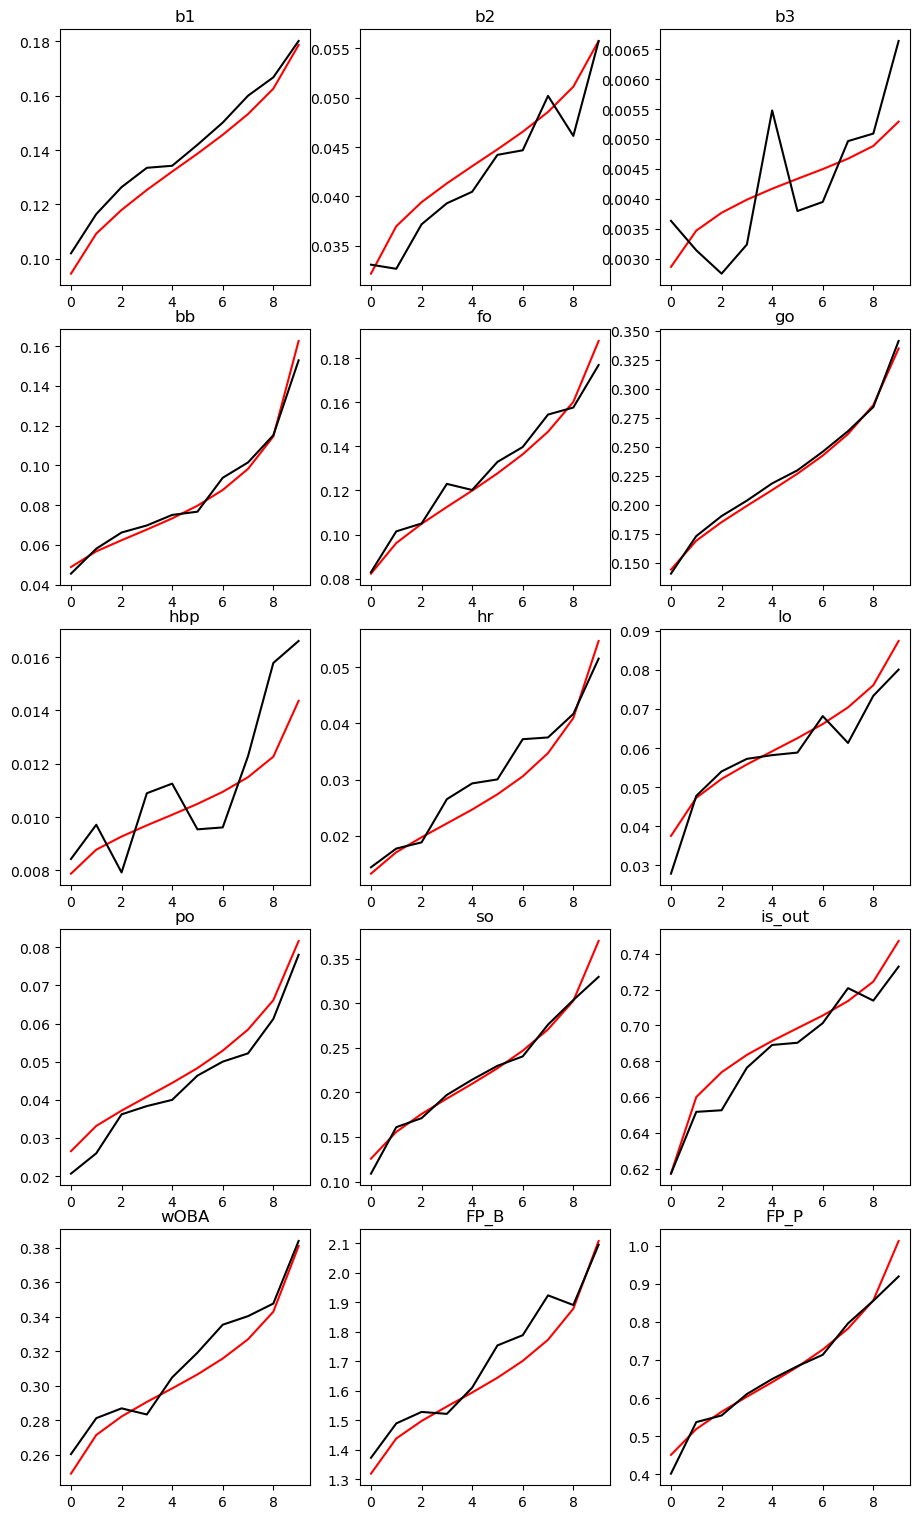

Model 3: predict_all_adjusted_16_79809_20250812.sav
Voting Classifier

Imputation Status x Starter
                  FP_P_pred  FP_P_act  wOBA_pred  wOBA_act  so_pred   so_act
imp_p    starter                                                            
0.000000 0         0.716115  0.699360   0.301862  0.304471 0.242104 0.235091
         1         0.680987  0.668573   0.307080  0.310887 0.225898 0.220756
1.000000 0         0.671622  0.684454   0.315868  0.308740 0.224266 0.229723
         1         0.618598  0.617412   0.327295  0.338876 0.200485 0.201149

Pitcher: Imputation Status
          FP_P_pred  FP_P_act  wOBA_pred  wOBA_act  so_pred   so_act
imp_p                                                               
0.000000   0.695113  0.680953   0.304982  0.308307 0.232415 0.226520
1.000000   0.650234  0.657412   0.320477  0.320896 0.214673 0.218198

Batter: Imputation Status
          FP_B_pred  FP_B_act  wOBA_pred  wOBA_act  hr_pred   hr_act
imp_b                                  

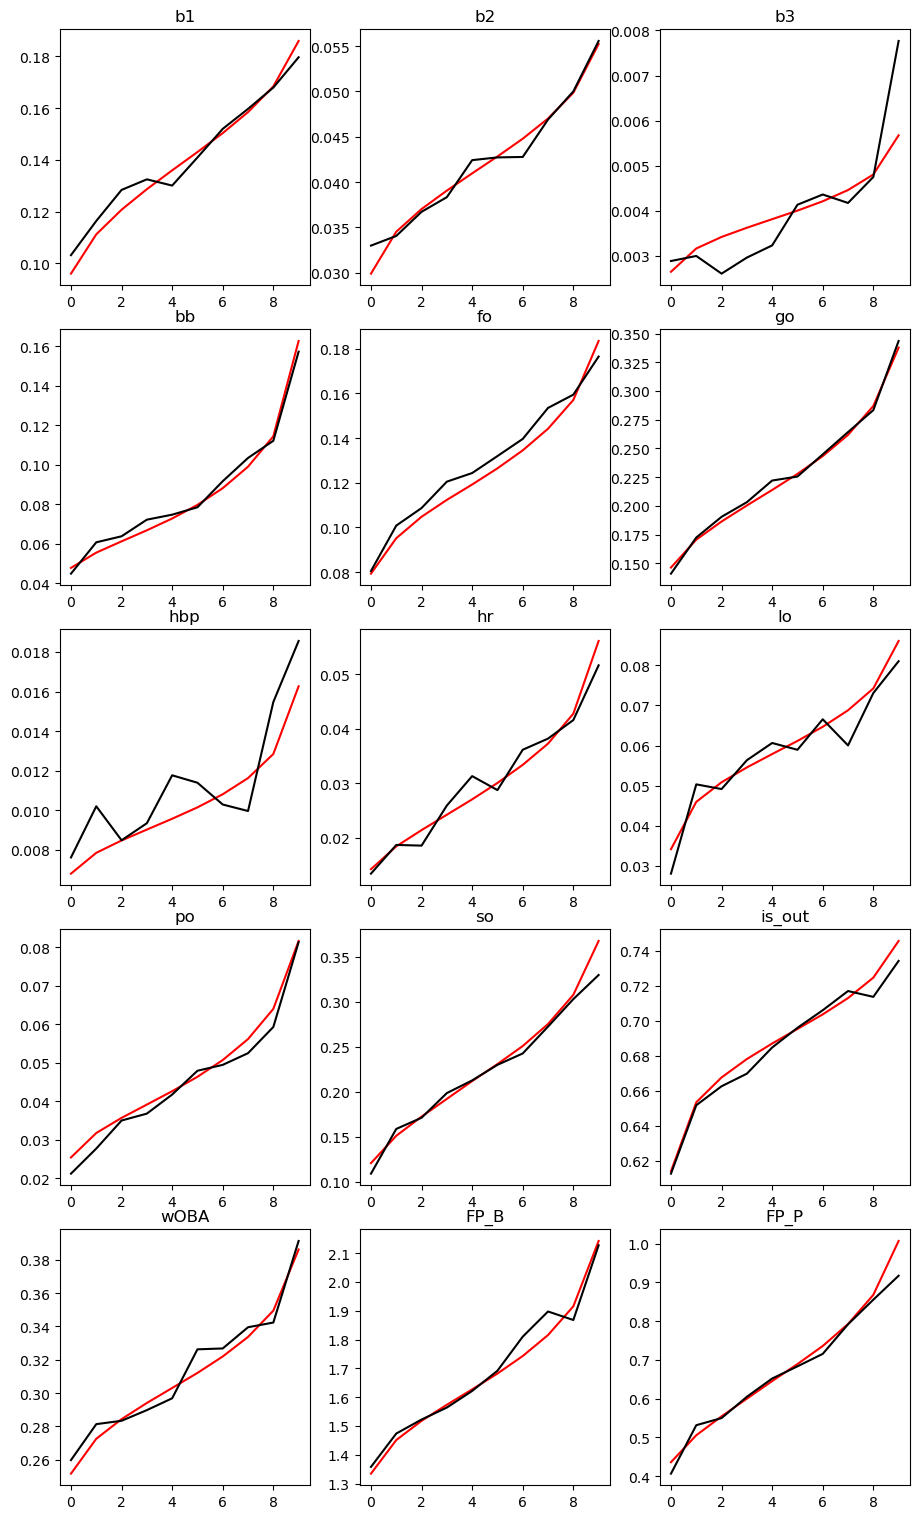

Model 4: predict_all_adjusted_16_79810_20250812.sav
Voting Classifier

Imputation Status x Starter
                  FP_P_pred  FP_P_act  wOBA_pred  wOBA_act  so_pred   so_act
imp_p    starter                                                            
0.000000 0         0.706553  0.699360   0.306056  0.304471 0.238286 0.235091
         1         0.671193  0.668573   0.311259  0.310887 0.221992 0.220756
1.000000 0         0.665809  0.684454   0.318528  0.308740 0.221913 0.229723
         1         0.615228  0.617412   0.328078  0.338876 0.199014 0.201149

Pitcher: Imputation Status
          FP_P_pred  FP_P_act  wOBA_pred  wOBA_act  so_pred   so_act
imp_p                                                               
0.000000   0.685412  0.680953   0.309167  0.308307 0.228544 0.226520
1.000000   0.645407  0.657412   0.322380  0.320896 0.212677 0.218198

Batter: Imputation Status
          FP_B_pred  FP_B_act  wOBA_pred  wOBA_act  hr_pred   hr_act
imp_b                                  

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000021A5A7FC730>>
Traceback (most recent call last):
  File "C:\Users\james\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 788, in _clean_thread_parent_frames
    if phase != "start":
KeyboardInterrupt: 


KeyboardInterrupt: 

In [86]:
%%time
for i in range(num_models):
    # Set filename
    all_adjusted_filename = f"predict_all_adjusted_{''.join(str(x) for x in layers)}_{random_state+i}_{todaysdate}.sav"
    print(f"Model {i}: {all_adjusted_filename}")

    # Determine if voting
    if num_classifiers > 1:
        print("Voting Classifier")
        # Build list of MLP classifiers with varied random_state
        estimators = []
        for j in range(num_classifiers):
            clf = MLPClassifier(
                hidden_layer_sizes=layers,
                activation=activation,
                verbose=True,
                alpha=alpha,
                learning_rate_init=learning_rate_init,
                early_stopping=early_stopping,
                random_state=random_state + i + j * 100,
                max_iter=max_iter,
                tol=tol,
                n_iter_no_change=n_iter_no_change,
                batch_size=batch_size
            )
            estimators.append((f"mlp_{j}", clf))
        
        # Combine into a soft voting classifier
        predict_all_adjusted = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)    
    else:
        print("Single Classifier")
        # Create Model
        predict_all_adjusted = MLPClassifier(hidden_layer_sizes=layers, 
                                             activation=activation, 
                                             verbose=True, 
                                             alpha=alpha, 
                                             learning_rate_init=learning_rate_init, 
                                             early_stopping=early_stopping, 
                                             random_state=random_state+i, 
                                             max_iter=max_iter,
                                             tol=tol, 
                                             n_iter_no_change=n_iter_no_change,
                                             batch_size=batch_size, 
                                             validation_fraction=validation_fraction)


    # Fit
    predict_all_adjusted.fit(model_dataset[training_mask][all_adjusted_input_list], model_dataset[training_mask][['eventsModel']].values.ravel())

    # Save model
    pickle.dump(predict_all_adjusted, open(os.path.join(model_path, "M03. Plate Appearances", all_adjusted_filename), 'wb'))
    
    # Predict all types
    all_outputs = list(predict_all_adjusted.classes_)
    all_outputs_pred = [x + "_pred" for x in all_outputs]
    
    model_dataset.loc[~training_mask, all_outputs_pred] = predict_all_adjusted.predict_proba(model_dataset[~training_mask][all_adjusted_input_list])

    ### Constructed Stats
    model_dataset = constructed_stats(model_dataset)


    ### Summary Statistics
    print("\nImputation Status x Starter")
    print(model_dataset[~training_mask].query('year == 2024').groupby(['imp_p', 'starter'])[['FP_P_pred', 'FP_P_act', 'wOBA_pred', 'wOBA_act', 'so_pred', 'so_act']].mean())
    print("\nPitcher: Imputation Status")
    print(model_dataset[~training_mask].query('year == 2024').groupby(['imp_p'])[['FP_P_pred', 'FP_P_act', 'wOBA_pred', 'wOBA_act', 'so_pred', 'so_act']].mean())
    print("\nBatter: Imputation Status")
    print(model_dataset[~training_mask].query('year == 2024').groupby(['imp_b'])[['FP_B_pred', 'FP_B_act', 'wOBA_pred', 'wOBA_act', 'hr_pred', 'hr_act']].mean())
    print("\nVenue")
    print(model_dataset[~training_mask].query('year == 2024').groupby('venue_id')[['FP_B_pred', 'FP_B_act', 'FP_P_pred', 'FP_P_act']].mean())
    print("\nHR Deciles")
    model_dataset['hr_wfx_quantile'] = pd.qcut(model_dataset['hr_wfx'], q=quantiles, labels=False) + 1
    print(model_dataset[~training_mask].groupby('hr_wfx_quantile')[['hr_pred', 'hr_act']].mean())
    print("\n")
    
    ### Quantiles
    # Loop over metrics
    for var in all_outputs + ['is_out', 'wOBA', 'FP_B', 'FP_P']:        
        # Calculate quantiles
        model_dataset.loc[~training_mask, f'{var}_quantile'] = pd.qcut(model_dataset.loc[~training_mask, f'{var}_pred'], quantiles, labels=False, duplicates='drop')
        
        # Create aggregated dataframe
        globals()[f"{var}_df"] = model_dataset.loc[~training_mask].groupby(f'{var}_quantile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
        globals()[f"{var}_year_df"] = model_dataset.query(f'year >= {year}').loc[~training_mask].groupby(f'{var}_quantile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
        globals()[f"{var}_venue_df"] = model_dataset.query(f'venue_id == {venue}').loc[~training_mask].groupby(f'{var}_quantile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
    
    ### All Years
    all_df_list = []
    for var in all_outputs + ['is_out', 'wOBA', 'FP_B', 'FP_P']:
        actual = model_dataset.loc[~training_mask][f'{var}_act'].mean()
        predicted = model_dataset.loc[~training_mask][f'{var}_pred'].mean()
        mult = actual/predicted
        stdev = model_dataset.loc[~training_mask][f'{var}_pred'].std()
        globals()[f"{var}_df"]['se'] = (globals()[f"{var}_df"][f'{var}_act'] - globals()[f"{var}_df"][f'{var}_pred']) ** 2
        mse = globals()[f"{var}_df"]['se'].mean()
        all_df = pd.DataFrame(["All", var, actual, predicted, mult, stdev, mse])
        all_df_list.append(all_df)
    
    all_dfs = pd.concat(all_df_list, axis=1).T
    
    ### Specific Year
    recent_df_list = []
    for var in all_outputs + ['is_out', 'wOBA', 'FP_B', 'FP_P']:
        actual = model_dataset.query(f'year >= {year}').loc[~training_mask][f'{var}_act'].mean()
        predicted = model_dataset.query(f'year == {year}').loc[~training_mask][f'{var}_pred'].mean()
        mult = actual/predicted
        stdev = model_dataset.query(f'year == {year}').loc[~training_mask][f'{var}_pred'].std()
        globals()[f"{var}_year_df"]['se'] = (globals()[f"{var}_year_df"][f'{var}_act'] - globals()[f"{var}_year_df"][f'{var}_pred']) ** 2
        mse = globals()[f"{var}_year_df"]['se'].mean()
        recent_df = pd.DataFrame([str(int(year)), var, actual, predicted, mult, stdev, mse])
        recent_df_list.append(recent_df)
    
    recent_dfs = pd.concat(recent_df_list, axis=1).T
    
    ### Outcome Summary
    all_stat_df = pd.concat([all_dfs, recent_dfs], axis=0).reset_index(drop=True)
    all_stat_df.columns = ['Year', 'Output', 'Actual', 'Predicted', "Multiplier", 'Std. Dev', 'MSE']
    all_stat_df['File'] = all_adjusted_filename
    all_stat_df['Layers'] = str(layers)
    all_stat_df['Models'] = num_models
    all_stat_df['State'] = random_state+i
    all_stat_df[['Year', 'File', 'Layers', 'Models', 'State', 'Output', 'Actual', 'Predicted', "Multiplier", 'Std. Dev', 'MSE']]

    print(all_stat_df[['Year', 'Output', 'Actual', 'Predicted', 'Multiplier', 'Std. Dev', 'MSE']])
    
    all_adjusted_stat_list.append(all_stat_df)


    
    ### Graphs
    graph_options = ["", "_year", "_venue"]
    graph_index = 1
    graph = graph_options[graph_index]
    print(f"Graphing {graph}")

    rows, columns = 5, 3
    fig, axs = plt.subplots(rows, columns, figsize=(9, 15))
    
    # Ensure that the number of plots doesn't exceed available subplots
    total_plots = rows * columns
    output_vars = all_outputs + ['is_out', 'wOBA', 'FP_B', 'FP_P']
    
    # Limit the number of plots to the available subplots
    output_vars = output_vars[:total_plots]
    
    for i, var in enumerate(output_vars):
        row = i // columns  # Calculate the row index based on the iteration
        col = i % columns   # Calculate the column index based on the iteration
        axs[row, col].plot(globals()[f"{var}{graph}_df"][f'{var}_quantile'], globals()[f"{var}{graph}_df"][f'{var}_pred'], color='red')
        axs[row, col].plot(globals()[f"{var}{graph}_df"][f'{var}_quantile'], globals()[f"{var}{graph}_df"][f'{var}_act'], color='black')
        axs[row, col].set_title(var)
    
    # Add some space between subplots to prevent overlapping
    fig.tight_layout(pad=.0)
    
    # Show the figure
    plt.show()


In [89]:
all_adjusted_stat_df = pd.concat(all_adjusted_stat_list)
all_adjusted_stat_df = all_adjusted_stat_df.reset_index(drop=True)

In [90]:
subset = all_adjusted_stat_df.query('Year == "2024"').query('Output == "wOBA"').query('1.01 > Multiplier > 0.99').reset_index(drop=True)
pareto_front = pareto_optimal(subset, ['MSE', 'Std. Dev'], ['Minimize', 'Maximize']).sort_values('Std. Dev')
pareto_front

,Year,Output,Actual,Predicted,Multiplier,Std. Dev,MSE,File,Layers,Models,State
0,2024,wOBA,0.308427,0.306643,1.005819,0.036539,0.000037,predict_all_adjusted_16_79807_20250812.sav,"(16,)",40,79807
1,2024,wOBA,0.308427,0.305869,1.008363,0.037174,0.000054,predict_all_adjusted_16_79809_20250812.sav,"(16,)",40,79809
